# 1. 2023.01~2023.12 화재예측

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [25]:
# 데이터파일 불러오기
df_fire = pd.read_csv('./data/preprocessed_fire_data.csv')
df_buildings = pd.read_csv('./data/preprocessed_buildings.csv')
df_pop = pd.read_csv('./data/coorded_old_population.csv')
df_weather = pd.read_csv('./data/preprocessed_weather.csv')

In [26]:
# 랜덤포레스트 모델 불러오기
import joblib

rf_best_over = joblib.load('./rf_model_over.pkl')

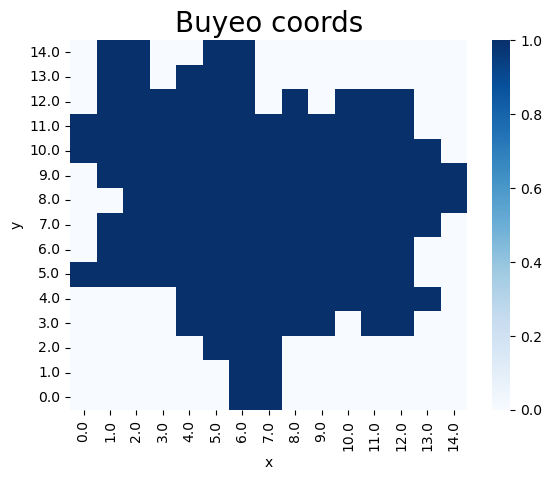

In [27]:
# 부여가 포함된 좌표만 걸러내기
# 인구분포 데이터와 화재 데이터를 결합하여 부여에 해당하는 좌표 얻기
df_pop_xy = df_pop.loc[:, ['x', 'y']]
df_fire_xy = df_fire.loc[:, ['x', 'y']]
df_buyeo = pd.concat([df_pop_xy, df_fire_xy])
df_buyeo = df_buyeo.drop_duplicates()
df_buyeo['val'] = 1
df_buyeo_heatmap = df_buyeo.pivot(index='y', columns='x', values='val').sort_index(ascending=False).fillna(0)
df_buyeo = df_buyeo.loc[:, ['x', 'y']]
ax = sns.heatmap(df_buyeo_heatmap, cmap='Blues')
plt.title('Buyeo coords', fontsize=20)
plt.show()

In [28]:
# 23년도 전체 날씨데이터에 접근할 수 없으므로 11년치 날씨데이터 평균내서 23년도 날씨로 예측
df_fut_weather = df_weather.groupby(['월']).mean().drop(columns=['년', '일']).reset_index()
df_fut_weather

,월,평균기온(°C),최저기온(°C),최고기온(°C),평균 상대습도\n(%),일강수량(mm),평균 풍속(m/s)
0,1,-1.385337,-6.638710,4.651320,70.536364,0.769208,1.095015
1,2,0.779100,-4.882637,6.999035,64.272669,1.268810,1.366238
2,3,6.487977,0.058944,13.654839,65.741056,1.687390,1.443695
3,4,12.153030,5.453333,19.492727,65.420909,3.007273,1.539697
4,5,17.850733,11.487683,24.984751,67.973314,2.524047,1.448387
5,6,22.465455,17.652727,28.330303,74.122424,3.181818,1.312727
6,7,25.499413,22.031378,30.218182,81.592082,8.357771,1.343988
7,8,26.061584,22.282991,30.991789,80.671554,8.670968,1.328446
8,9,20.905455,16.365152,26.711212,78.428485,4.710606,1.191515
9,10,14.124047,8.520235,21.224340,76.725513,2.747214,1.041935


In [29]:
# 좌표별 임야 화재 횟수 세기
df_field_fire = df_fire[df_fire['화재구분'] == '임야'].groupby(['x', 'y']).count().loc[:, ['화재구분']].reset_index()
df_field_fire.head()

,x,y,화재구분
0,0.0,5.0,1
1,0.0,10.0,2
2,1.0,5.0,3
3,1.0,6.0,1
4,1.0,7.0,2


In [30]:
# 좌표별 비닐하우스 화재 횟수 세기
df_green_fire = df_fire[df_fire['화재구분'] == '비닐하우스'].groupby(['x', 'y']).count().loc[:, ['화재구분']].reset_index()
df_green_fire.head()

,x,y,화재구분
0,0.0,11.0,2
1,1.0,5.0,1
2,1.0,6.0,2
3,1.0,10.0,1
4,1.0,11.0,1


In [31]:
# 날짜와 좌표의 모든 조합 구하기
import itertools

year = [2023]
month = list(np.arange(start=1, stop=13))
full_date = list(itertools.product(year, month))
buyeo_coords = df_buyeo.values.tolist()

date_coords = list(itertools.product(full_date, buyeo_coords))
len(date_coords)

1632

In [32]:
# 예측할 컬럼 데이터들 종합하여 데이터프레임 생성
pred_feats = []

for date_coord in date_coords:
    feat = []
    # 날짜 및 좌표부터 추가: 년, 월, x, y
    feat.append(date_coord[0][0]) 
    feat.append(date_coord[0][1]) 
    feat.append(date_coord[1][0])
    feat.append(date_coord[1][1])

    # 인구수비율 및 노인인구수비율 추가: 인구수비율, 60세이상노인인구수비율
    pop_result =  df_pop[
        (df_pop['연도'] == 2022) &
        (df_pop['x'] == date_coord[1][0]) &
        (df_pop['y'] == date_coord[1][1])
    ]

    if len(pop_result) == 0:
        feat.append(0.)
        feat.append(0.)
    else:
        feat.append(pop_result.iloc[0]['인구수비율'])
        feat.append(pop_result.iloc[0]['60세이상노인인구수비율'])

    # 날짜 및 좌표별 창고개수 추가: 창고개수
    storage_date = int(str(2022) + str('{:02d}'.format(date_coord[0][1])) + str(15))
    storage_result = df_buildings.loc[
        (df_buildings['x'] == date_coord[1][0]) &
        (df_buildings['y'] == date_coord[1][1]) &
        (df_buildings['신고일'] <= storage_date) & 
        (df_buildings['실질적철거일'] >= storage_date) &
        (df_buildings['기타용도'] == '창고')
    ]

    feat.append(len(storage_result))

    # 날짜 및 좌표별 축사, 균사개수 추가: 축균사개수
    barn_spawn_date = int(str(2022) + str('{:02d}'.format(date_coord[0][1])) + str(15))
    barn_spawn_result = df_buildings.loc[
        (df_buildings['x'] == date_coord[1][0]) &
        (df_buildings['y'] == date_coord[1][1]) &
        (df_buildings['신고일'] <= barn_spawn_date) & 
        (df_buildings['실질적철거일'] >= barn_spawn_date) &
        ((df_buildings['기타용도'] == '축사') | (df_buildings['기타용도'] == '균사'))
    ]

    feat.append(len(barn_spawn_result))
    
    # 날씨 데이터 추가: 평균기온, 최저기온, 최고기온, 평균 상대습도, 일강수량, 평균 풍속
    weather_result = df_fut_weather[
        df_fut_weather['월'] == date_coord[0][1]
    ]

    feat.append(weather_result.iloc[0]['평균기온(°C)'])
    feat.append(weather_result.iloc[0]['최저기온(°C)'])
    feat.append(weather_result.iloc[0]['최고기온(°C)'])
    feat.append(weather_result.iloc[0]['평균 상대습도\n(%)'])
    feat.append(weather_result.iloc[0]['일강수량(mm)'])
    feat.append(weather_result.iloc[0]['평균 풍속(m/s)'])

    # 좌표별 임야화재횟수 추가: 임야화재횟수
    field_result = df_field_fire[
        (df_field_fire['x'] == date_coord[1][0]) & 
        (df_field_fire['y'] == date_coord[1][1])
    ]

    if len(field_result) == 0:
        feat.append(0.)
    else:
        feat.append(field_result.iloc[0]['화재구분'])

    # 좌표별 비닐하우스화재횟수 추가: 비닐하우스화재횟수
    green_result = df_green_fire[
        (df_green_fire['x'] == date_coord[1][0]) & 
        (df_green_fire['y'] == date_coord[1][1])
    ]

    if len(green_result) == 0:
        feat.append(0.)
    else:
        feat.append(green_result.iloc[0]['화재구분'])

    pred_feats.append(feat)

In [33]:
# 최종 컬럼
# 년, 월, x, y, 인구수비율, 60세이상노인인구수비율, 창고개수, 축균사개수, 평균기온, 최저기온, 최고기온, 평균상대습도, 
# 일강수량, 평균풍속, 임야화재횟수, 비닐하우스화재횟수
fut_df = pd.DataFrame(pred_feats, columns=[
    'year', 'month', 'x', 'y', 'pop_rate', 'old_pop_rate', 'sto_num', 'barn_spwn_num', 'avg_temp', 'min_temp', 'max_temp', 'avg_hum', 
    'daily_pre', 'avg_wind', 'field_fire', 'green_fire'
])
print(len(fut_df))
fut_df.head()

1632


,year,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire
0,2023,1,0.0,11.0,0.010901,0.012014,5,0,-1.385337,-6.63871,4.65132,70.536364,0.769208,1.095015,0.0,2.0
1,2023,1,1.0,5.0,0.004584,0.006429,8,1,-1.385337,-6.63871,4.65132,70.536364,0.769208,1.095015,3.0,1.0
2,2023,1,1.0,6.0,0.005604,0.007338,8,2,-1.385337,-6.63871,4.65132,70.536364,0.769208,1.095015,1.0,2.0
3,2023,1,1.0,7.0,0.002089,0.002987,6,1,-1.385337,-6.63871,4.65132,70.536364,0.769208,1.095015,2.0,0.0
4,2023,1,1.0,9.0,0.001263,0.001916,7,0,-1.385337,-6.63871,4.65132,70.536364,0.769208,1.095015,0.0,0.0


In [34]:
# 스케일링 위해 전체 데이터 가져오기
full_df = pd.read_csv('./data/non_scaled_data.csv').drop(columns=['fire'])
print(len(full_df))
full_df.head()

17952


,year,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire
0,2012,1,0.0,11.0,0.012300,0.012723,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,0.0,0.0
1,2012,1,1.0,5.0,0.004109,0.007010,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,3.0,3.0
2,2012,1,1.0,6.0,0.005297,0.008671,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,1.0,1.0
3,2012,1,1.0,7.0,0.001939,0.002958,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,2.0,2.0
4,2012,1,1.0,9.0,0.001038,0.001661,0,0,-1.4,-6.1,0.9,73.0,1.5,1.6,0.0,0.0


In [35]:
# 전체 데이터와 예측할 데이터를 같이 묶기
fut_df = pd.concat([fut_df, full_df], axis=0)

In [36]:
# 전체 데이터를 포함하여 MinMaxScaler로 스케일링
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
fut_df['x'] = scaler.fit_transform(fut_df['x'].values.reshape(-1, 1))
fut_df['y'] = scaler.fit_transform(fut_df['y'].values.reshape(-1, 1))
fut_df['pop_rate'] = scaler.fit_transform(fut_df['pop_rate'].values.reshape(-1, 1))
fut_df['old_pop_rate'] = scaler.fit_transform(fut_df['old_pop_rate'].values.reshape(-1, 1))
fut_df['sto_num'] = scaler.fit_transform(fut_df['sto_num'].values.reshape(-1, 1))
fut_df['barn_spwn_num'] = scaler.fit_transform(fut_df['barn_spwn_num'].values.reshape(-1, 1))
fut_df['avg_temp'] = scaler.fit_transform(fut_df['avg_temp'].values.reshape(-1, 1))
fut_df['min_temp'] = scaler.fit_transform(fut_df['min_temp'].values.reshape(-1, 1))
fut_df['max_temp'] = scaler.fit_transform(fut_df['max_temp'].values.reshape(-1, 1))
fut_df['avg_hum'] = scaler.fit_transform(fut_df['avg_hum'].values.reshape(-1, 1))
fut_df['daily_pre'] = scaler.fit_transform(fut_df['daily_pre'].values.reshape(-1, 1))
fut_df['avg_wind'] = scaler.fit_transform(fut_df['avg_wind'].values.reshape(-1, 1))
fut_df['field_fire'] = scaler.fit_transform(fut_df['field_fire'].values.reshape(-1, 1))
fut_df['green_fire'] = scaler.fit_transform(fut_df['green_fire'].values.reshape(-1, 1))

In [37]:
# 예측할 데이터만 분리
fut_df = fut_df.iloc[:1632].drop(columns=['year'])
fut_df.head()

,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire
0,1,0.000000,0.785714,0.087905,0.165105,0.094340,0.000000,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.000000,0.142857
1,1,0.071429,0.357143,0.036964,0.088353,0.150943,0.166667,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.214286,0.071429
2,1,0.071429,0.428571,0.045193,0.100848,0.150943,0.333333,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.071429,0.142857
3,1,0.071429,0.500000,0.016850,0.041053,0.113208,0.166667,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.142857,0.000000
4,1,0.071429,0.642857,0.010188,0.026328,0.132075,0.000000,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.000000,0.000000


In [38]:
# 데이터로 예측 진행
# SMOTE oversampling 랜덤포레스트 사용
fut_y = rf_best_over.predict(fut_df)
fut_df['fire'] = fut_y
fut_df.head()

,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire,fire
0,1,0.000000,0.785714,0.087905,0.165105,0.094340,0.000000,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.000000,0.142857,0.0
1,1,0.071429,0.357143,0.036964,0.088353,0.150943,0.166667,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.214286,0.071429,0.0
2,1,0.071429,0.428571,0.045193,0.100848,0.150943,0.333333,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.071429,0.142857,0.0
3,1,0.071429,0.500000,0.016850,0.041053,0.113208,0.166667,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.142857,0.000000,0.0
4,1,0.071429,0.642857,0.010188,0.026328,0.132075,0.000000,0.145458,0.13392,0.168721,0.495154,0.004113,0.240914,0.000000,0.000000,0.0


In [39]:
# 예측한 데이터들의 좌표를 스케일링 이전으로 변환
df_map = fut_df.loc[:, ['month', 'x', 'y', 'fire']]
df_map['x'] = (df_map['x'] * 14).apply(lambda x: np.ceil(x))
df_map['y'] = (df_map['y'] * 14).apply(lambda x: np.ceil(x))
df_map.head()

,month,x,y,fire
0,1,0.0,11.0,0.0
1,1,1.0,5.0,0.0
2,1,1.0,6.0,0.0
3,1,1.0,7.0,0.0
4,1,1.0,9.0,0.0


In [40]:
# 화재 예측 좌표만 정확하게 예측하는 것은 어렵기에 예측한 좌표의 주변 좌표를 예방지역으로 선정, 0.5의 부여
# 즉 화재예측지역은 1, 해당지역 주변지역은 0.5로 변환
check_coord = df_map.loc[:, ['month', 'x', 'y']].values.tolist()
for idx in df_map[df_map['fire'] == 1].index:
    month = df_map.iloc[idx]['month']
    x = df_map.iloc[idx]['x']
    y = df_map.iloc[idx]['y']
    if [month, x+1, y] in check_coord:
        i = df_map[(df_map['month'] == month) & (df_map['x'] == x+1) & (df_map['y'] == y)].index[0]
        if df_map.iloc[i, df_map.columns.get_loc('fire')] != 1:
            df_map.iloc[i, df_map.columns.get_loc('fire')] = 0.5
    if [month, x-1, y] in check_coord:
        i = df_map[(df_map['month'] == month) & (df_map['x'] == x-1) & (df_map['y'] == y)].index[0]
        if df_map.iloc[i, df_map.columns.get_loc('fire')] != 1:
            df_map.iloc[i, df_map.columns.get_loc('fire')] = 0.5
    if [month, x, y+1] in check_coord:
        i = df_map[(df_map['month'] == month) & (df_map['x'] == x) & (df_map['y'] == y+1)].index[0]
        if df_map.iloc[i, df_map.columns.get_loc('fire')] != 1:
            df_map.iloc[i, df_map.columns.get_loc('fire')] = 0.5
    if [month, x, y-1] in check_coord:
        i = df_map[(df_map['month'] == month) & (df_map['x'] == x) & (df_map['y'] == y-1)].index[0]
        if df_map.iloc[i, df_map.columns.get_loc('fire')] != 1:
            df_map.iloc[i, df_map.columns.get_loc('fire')] = 0.5
    if [month, x+1, y+1] in check_coord:
        i = df_map[(df_map['month'] == month) & (df_map['x'] == x+1) & (df_map['y'] == y+1)].index[0]
        if df_map.iloc[i, df_map.columns.get_loc('fire')] != 1:
            df_map.iloc[i, df_map.columns.get_loc('fire')] = 0.5
    if [month, x+1, y-1] in check_coord:
        i = df_map[(df_map['month'] == month) & (df_map['x'] == x+1) & (df_map['y'] == y-1)].index[0]
        if df_map.iloc[i, df_map.columns.get_loc('fire')] != 1:
            df_map.iloc[i, df_map.columns.get_loc('fire')] = 0.5
    if [month, x-1, y+1] in check_coord:
        i = df_map[(df_map['month'] == month) & (df_map['x'] == x-1) & (df_map['y'] == y+1)].index[0]
        if df_map.iloc[i, df_map.columns.get_loc('fire')] != 1:
            df_map.iloc[i, df_map.columns.get_loc('fire')] = 0.5
    if [month, x-1, y-1] in check_coord:
        i = df_map[(df_map['month'] == month) & (df_map['x'] == x-1) & (df_map['y'] == y-1)].index[0]
        if df_map.iloc[i, df_map.columns.get_loc('fire')] != 1:
            df_map.iloc[i, df_map.columns.get_loc('fire')] = 0.5

In [41]:
# 예측한 월별 화재예측 결과를 히트맵으로 변환
map_heatmap_1 = df_map[df_map['month'] == 1].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_2 = df_map[df_map['month'] == 2].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_3 = df_map[df_map['month'] == 3].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_4 = df_map[df_map['month'] == 4].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_5 = df_map[df_map['month'] == 5].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_6 = df_map[df_map['month'] == 6].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_7 = df_map[df_map['month'] == 7].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_8 = df_map[df_map['month'] == 8].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_9 = df_map[df_map['month'] == 9].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_10 = df_map[df_map['month'] == 10].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_11 = df_map[df_map['month'] == 11].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
map_heatmap_12 = df_map[df_map['month'] == 12].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)

Text(0.5, 1.0, '2023.12')

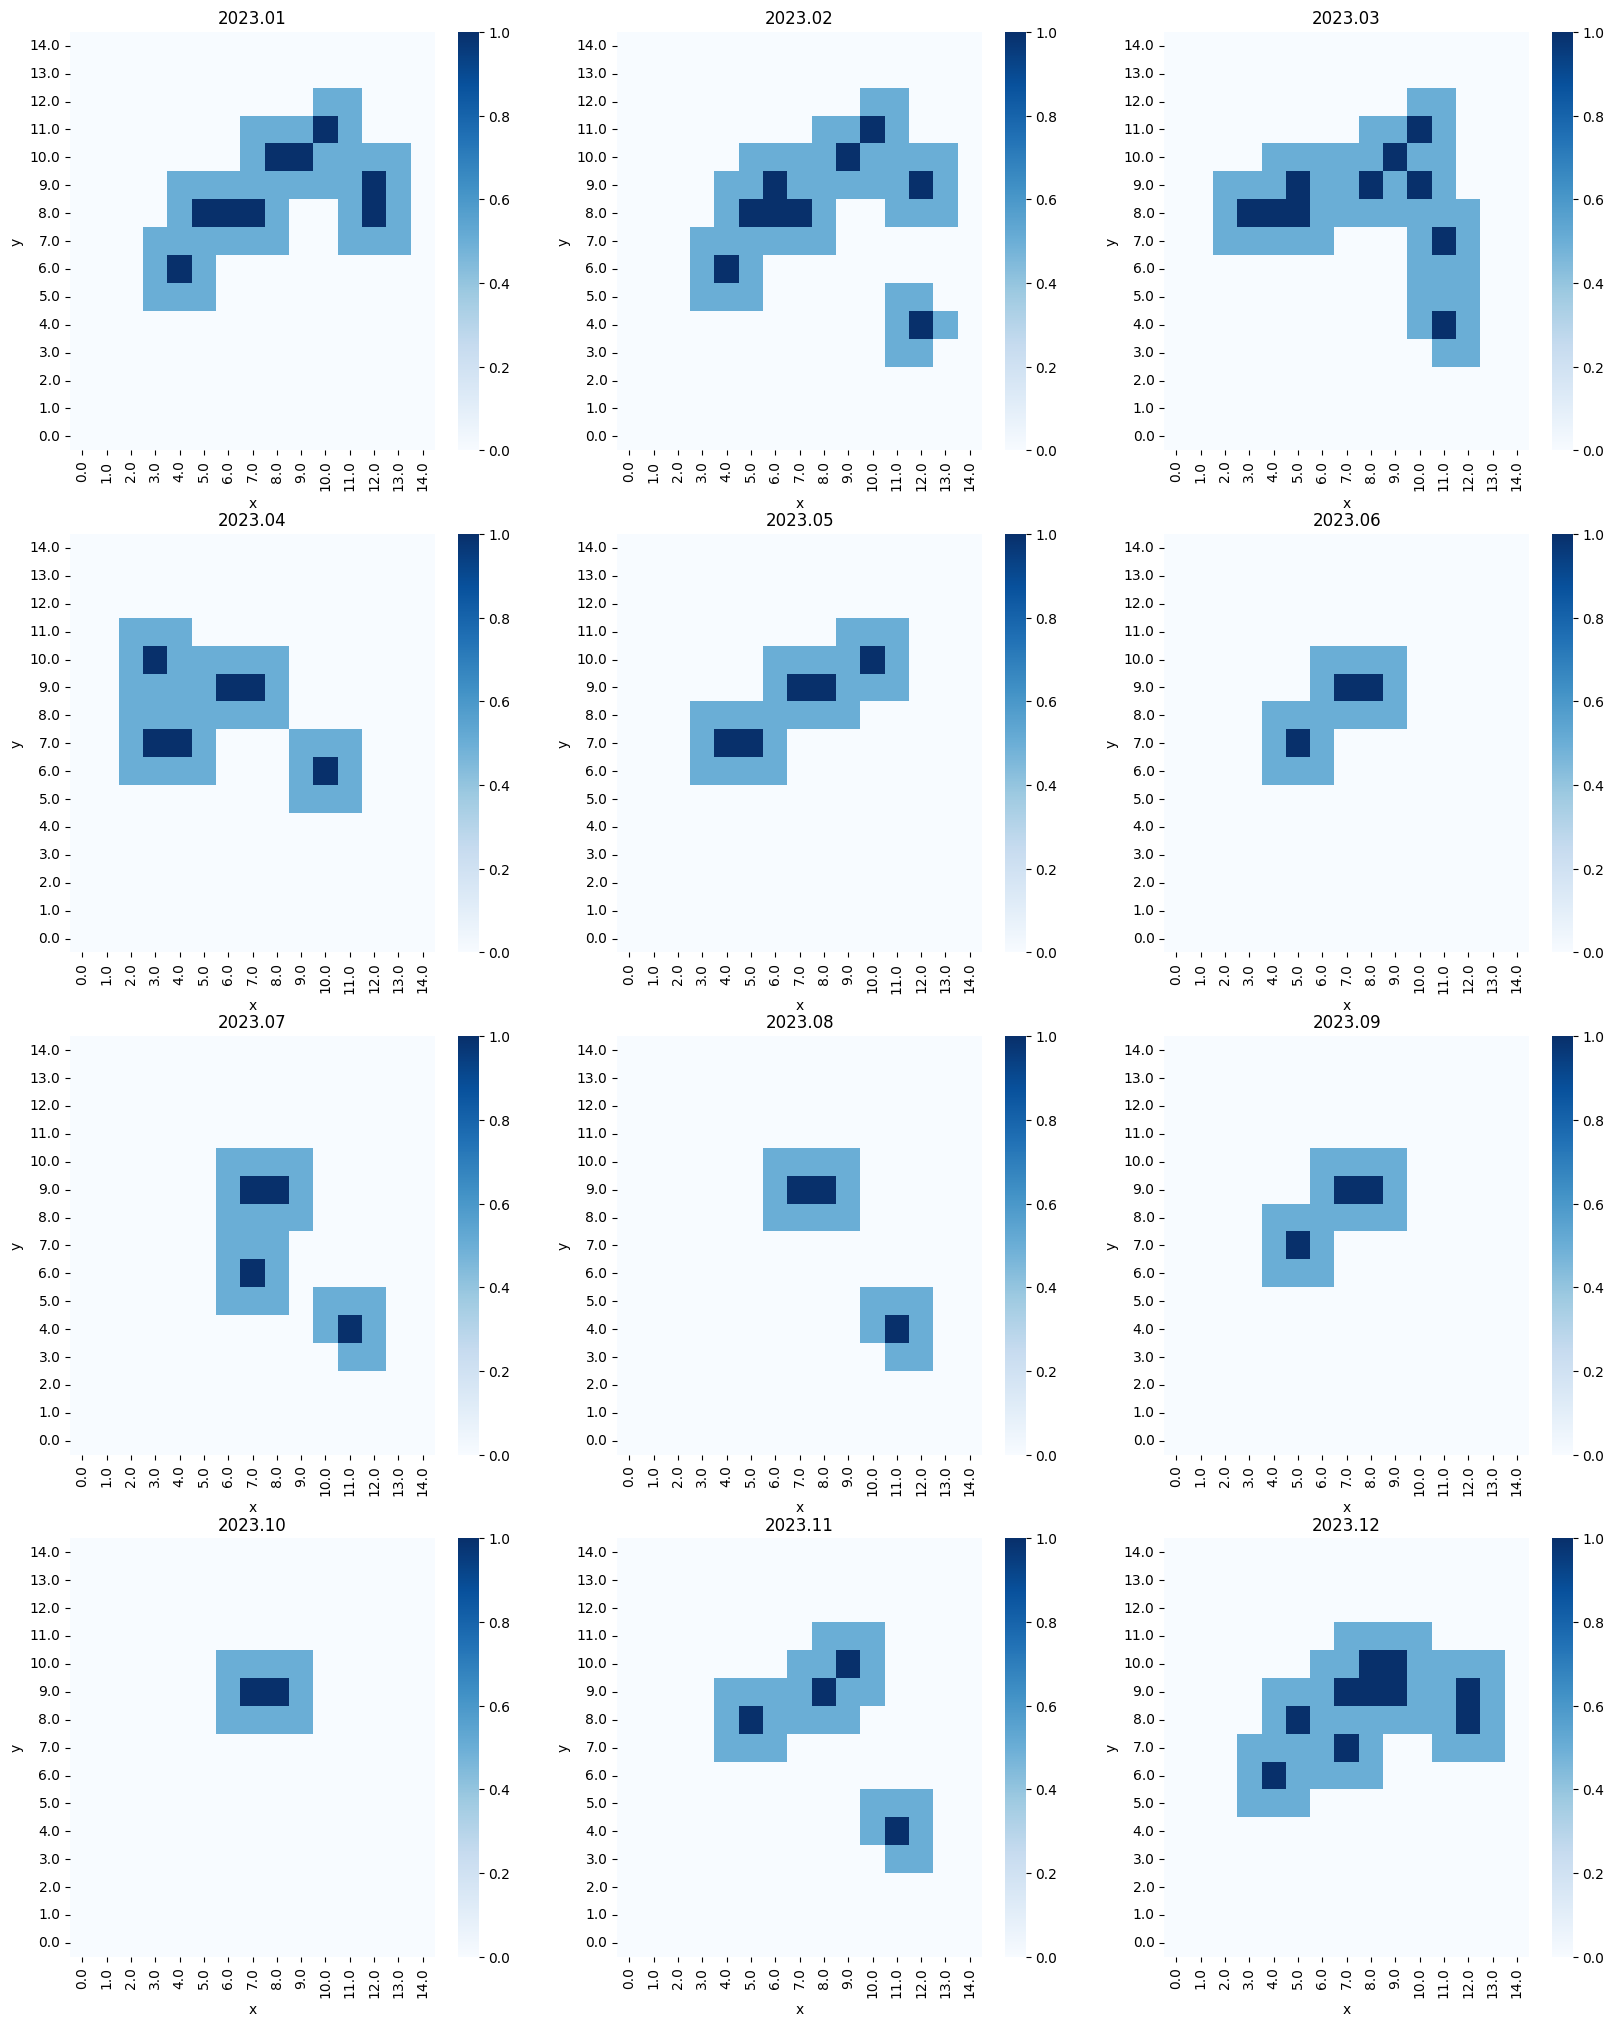

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(20, 25))

sns.heatmap(map_heatmap_1, cmap='Blues', ax=ax[0][0])
sns.heatmap(map_heatmap_2, cmap='Blues', ax=ax[0][1])
sns.heatmap(map_heatmap_3, cmap='Blues', ax=ax[0][2])
sns.heatmap(map_heatmap_4, cmap='Blues', ax=ax[1][0])
sns.heatmap(map_heatmap_5, cmap='Blues', ax=ax[1][1])
sns.heatmap(map_heatmap_6, cmap='Blues', ax=ax[1][2])
sns.heatmap(map_heatmap_7, cmap='Blues', ax=ax[2][0])
sns.heatmap(map_heatmap_8, cmap='Blues', ax=ax[2][1])
sns.heatmap(map_heatmap_9, cmap='Blues', ax=ax[2][2])
sns.heatmap(map_heatmap_10, cmap='Blues', ax=ax[3][0])
sns.heatmap(map_heatmap_11, cmap='Blues', ax=ax[3][1])
sns.heatmap(map_heatmap_12, cmap='Blues', ax=ax[3][2])

ax[0][0].set_title('2023.01')
ax[0][1].set_title('2023.02')
ax[0][2].set_title('2023.03')
ax[1][0].set_title('2023.04')
ax[1][1].set_title('2023.05')
ax[1][2].set_title('2023.06')
ax[2][0].set_title('2023.07')
ax[2][1].set_title('2023.08')
ax[2][2].set_title('2023.09')
ax[3][0].set_title('2023.10')
ax[3][1].set_title('2023.11')
ax[3][2].set_title('2023.12')

In [ ]:
# 예측된 2023년 화재 정보 저장
df_map.to_csv('./data/2023_prediction.csv', encoding='utf-8-sig', index=False)

# 2. 화재예측결과 지도 표시

In [43]:
import folium
import numpy as np
import pandas as pd

In [51]:
# 2023년 예측한 결과 데이터 불러오기
df_map = pd.read_csv('./data/2023_prediction.csv')
df_map.head()

,month,x,y,fire
0,1,0.0,11.0,0.0
1,1,1.0,5.0,0.0
2,1,1.0,6.0,0.0
3,1,1.0,7.0,0.0
4,1,1.0,9.0,0.0


In [52]:
# 부여 동서남북 가장 끝 좌표
LOWER = 36.0721
LEFT = 126.6796
UPPER = 36.3865
RIGHT = 127.07

In [53]:
# 15, 15 좌표를 원래의 위도, 경도 좌표계로 변환
df_map['lon'] = (RIGHT - LEFT) * df_map['x'] / 15. + LEFT 
df_map['lat'] = (UPPER - LOWER) * df_map['y'] / 15. + LOWER
df_map.head()

,month,x,y,fire,lon,lat
0,1,0.0,11.0,0.0,126.679600,36.30266
1,1,1.0,5.0,0.0,126.705627,36.17690
2,1,1.0,6.0,0.0,126.705627,36.19786
3,1,1.0,7.0,0.0,126.705627,36.21882
4,1,1.0,9.0,0.0,126.705627,36.26074


In [54]:
# 웹에서 사용할 csv 파일 위해 각 격자별 남서, 북동 좌표 계산
xs = (RIGHT - LEFT) / 15.
ys = (UPPER - LOWER) / 15.

df_map['sw_lat'] = df_map['lat']
df_map['sw_lon'] = df_map['lon']

df_map['ne_lat'] = df_map['lat'] + ys
df_map['ne_lon'] = df_map['lon'] + xs

df_map.head()

,month,x,y,fire,lon,lat,sw_lat,sw_lon,ne_lat,ne_lon
0,1,0.0,11.0,0.0,126.679600,36.30266,36.30266,126.679600,36.32362,126.705627
1,1,1.0,5.0,0.0,126.705627,36.17690,36.17690,126.705627,36.19786,126.731653
2,1,1.0,6.0,0.0,126.705627,36.19786,36.19786,126.705627,36.21882,126.731653
3,1,1.0,7.0,0.0,126.705627,36.21882,36.21882,126.705627,36.23978,126.731653
4,1,1.0,9.0,0.0,126.705627,36.26074,36.26074,126.705627,36.28170,126.731653


In [ ]:
# 웹에서 사용할 예측결과 저장
df_map.loc[:, ['month', 'sw_lat', 'sw_lon', 'ne_lat', 'ne_lon', 'fire']].to_csv('./data/2023_prediction_web.csv', encoding='utf-8-sig', index=False)

In [55]:
# 사각형 폴리곤 구성 꼭짓점 계산
def get_rectangle_points(lat, lon):
    x_size = (RIGHT - LEFT) / 15.
    y_size = (UPPER - LOWER) / 15.

    points = [
        [lat, lon],
        [lat, lon + x_size],
        [lat + y_size, lon + x_size],
        [lat + y_size, lon],
    ]

    return points

In [56]:
# month 변수 조정하여 화재예측범위 표시
# folium 기반으로 Github에서는 표시 안됨
gmap = folium.Map(location=((LOWER + UPPER) / 2, (LEFT + RIGHT) / 2), zoom_start=10)

month = 11

for idx in df_map[df_map['month'] == month].index:
    points = get_rectangle_points(df_map.loc[idx, 'lat'], df_map.loc[idx, 'lon'])

    if df_map.loc[idx, 'fire'] == 0.:
        folium.Polygon(locations=points, tooltip='Fire', opacity=0.3).add_to(gmap)
    elif df_map.loc[idx, 'fire'] == 0.5:
        folium.Polygon(locations=points, tooltip='Fire', opacity=0.3, fill=True, fillColor='red', fillOpacity=0.2).add_to(gmap)
    else:
        folium.Polygon(locations=points, tooltip='Fire', opacity=0.3, fill=True, fillColor='red', fillOpacity=0.6).add_to(gmap)

gmap

# 3. 2023.01~2023.06의 실제화재와 화재예측결과 비교

In [57]:
import json
import requests
import re

In [58]:
# 2023년 1월~6월 화재데이터 불러오기
df_2023 = pd.read_csv('./data/fire_2023_01_06.csv')

In [59]:
# 사용할 컬럼만 분해
df_2023 = df_2023.loc[:, ['화재발생(월)', '시도', '시군구', '읍면동', '지번리', '세부주소']]
df_2023.head()

,화재발생(월),시도,시군구,읍면동,지번리,세부주소
0,1,충청남도,부여군,규암면,신성리,2121 주택 마당
1,1,충청남도,부여군,은산면,가중리,1111
2,1,충청남도,부여군,홍산면,무정리,301
3,1,충청남도,부여군,세도면,장산리,1064
4,1,충청남도,부여군,내산면,지티리,1262


In [60]:
# 주소 병합
df_2023['군면리'] = df_2023['시군구'] + ' ' + df_2023['읍면동'] + ' ' + df_2023['지번리']
df_addr_2023 = df_2023[['군면리']]
df_addr_2023['세부주소'] = df_2023['세부주소'].apply(lambda x: x.split(' ')[0])
df_addr_2023.head()

,군면리,세부주소
0,부여군 규암면 신성리,2121
1,부여군 은산면 가중리,1111
2,부여군 홍산면 무정리,301
3,부여군 세도면 장산리,1064
4,부여군 내산면 지티리,1262


In [61]:
# 카카오맵 API
API_KEY = 'c8d2487b6ee1ee531c4b6899126efe7f'
headers = {'Authorization' : 'KakaoAK '+API_KEY}
headers

{'Authorization': 'KakaoAK c8d2487b6ee1ee531c4b6899126efe7f'}

In [62]:
# 위도 및 경도를 가져오는 함수
def getLat(addr):
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + addr
    result = json.loads(str(requests.get(url, headers=headers).text))
    if len(result['documents']) == 0:
        new_addr = re.sub(r'[0-9]+', '', addr)
        url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + new_addr
        result = json.loads(str(requests.get(url, headers=headers).text))

    match_first = result['documents'][0]['address']

    return float(match_first['y'])

def getLng(addr):
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + addr
    result = json.loads(str(requests.get(url, headers=headers).text))
    if len(result['documents']) == 0:
        new_addr = re.sub(r'[0-9]+', '', addr)
        url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + new_addr
        result = json.loads(str(requests.get(url, headers=headers).text))
        
    match_first = result['documents'][0]['address']
    return float(match_first['x'])

In [63]:
# 주소를 위도 경도로 변환
for i in range(len(df_addr_2023)):
    try:
        lng = getLng(df_addr_2023['군면리'][i] + df_addr_2023['세부주소'][i])
        lat = getLat(df_addr_2023['군면리'][i] + df_addr_2023['세부주소'][i])
        df_addr_2023.loc[i,['경도']] = lng
        df_addr_2023.loc[i,['위도']] = lat

    except:
        print('error',i)
        
    
    if i%100 == 0:
        print('{} 번째 주소에 대한 좌표정보 불러오는 중...'.format(i)) 

0 번째 주소에 대한 좌표정보 불러오는 중...
error 22


In [64]:
df_2023['경도'] = df_addr_2023['경도']
df_2023['위도'] = df_addr_2023['위도']
df_2023.head()

,화재발생(월),시도,시군구,읍면동,지번리,세부주소,군면리,경도,위도
0,1,충청남도,부여군,규암면,신성리,2121 주택 마당,부여군 규암면 신성리,126.881966,36.320330
1,1,충청남도,부여군,은산면,가중리,1111,부여군 은산면 가중리,126.844634,36.299416
2,1,충청남도,부여군,홍산면,무정리,301,부여군 홍산면 무정리,126.782041,36.240264
3,1,충청남도,부여군,세도면,장산리,1064,부여군 세도면 장산리,126.985269,36.177371
4,1,충청남도,부여군,내산면,지티리,1262,부여군 내산면 지티리,126.738454,36.283922


In [65]:
# 결측치 제거
print(len(df_2023))
df_2023 = df_2023.dropna(axis=0).reset_index(drop=True)
print(len(df_2023))

50
49


In [66]:
# 부여 동서남북 가장 끝 좌표
LOWER = 36.0721
LEFT = 126.6796
UPPER = 36.3865
RIGHT = 127.07

In [67]:
# 위도, 경도 15, 15 좌표계로 변환
df_2023['x'] = df_2023['경도'].astype(float).map(lambda x: np.trunc((x - LEFT) / ((RIGHT - LEFT) / 15.)))
df_2023['y'] = df_2023['위도'].astype(float).map(lambda x: np.trunc((x - LOWER) / ((UPPER - LOWER) / 15.)))
df_2023.head()

,화재발생(월),시도,시군구,읍면동,지번리,세부주소,군면리,경도,위도,x,y
0,1,충청남도,부여군,규암면,신성리,2121 주택 마당,부여군 규암면 신성리,126.881966,36.320330,7.0,11.0
1,1,충청남도,부여군,은산면,가중리,1111,부여군 은산면 가중리,126.844634,36.299416,6.0,10.0
2,1,충청남도,부여군,홍산면,무정리,301,부여군 홍산면 무정리,126.782041,36.240264,3.0,8.0
3,1,충청남도,부여군,세도면,장산리,1064,부여군 세도면 장산리,126.985269,36.177371,11.0,5.0
4,1,충청남도,부여군,내산면,지티리,1262,부여군 내산면 지티리,126.738454,36.283922,2.0,10.0


In [ ]:
# 필요컬럼만 남기고 저장
df_2023 = df_2023.loc[:, ['화재발생(월)', '경도', '위도', 'x', 'y']]
df_2023.to_csv('./data/pre_real_2023_fire.csv')

In [69]:
# 실제 화재데이터 정렬
df_real = df_2023.groupby(['화재발생(월)', 'x', 'y']).count().reset_index().loc[:, ['화재발생(월)', 'x', 'y']]
df_real['fire'] = 1.
df_real.head()

,화재발생(월),x,y,fire
0,1,2.0,6.0,1.0
1,1,2.0,10.0,1.0
2,1,3.0,7.0,1.0
3,1,3.0,8.0,1.0
4,1,6.0,10.0,1.0


In [70]:
# 데이터파일 불러오기
df_fire = pd.read_csv('./data/preprocessed_fire_data.csv')
df_buildings = pd.read_csv('./data/preprocessed_buildings.csv')
df_pop = pd.read_csv('./data/coorded_old_population.csv')
df_weather = pd.read_csv('./data/preprocessed_weather.csv')

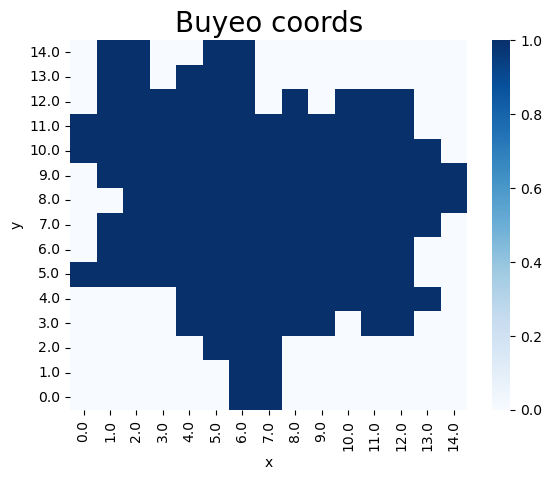

In [71]:
# 부여가 포함된 좌표만 걸러내기
# 인구분포 데이터와 화재 데이터를 결합하여 부여에 해당하는 좌표 얻기
df_pop_xy = df_pop.loc[:, ['x', 'y']]
df_fire_xy = df_fire.loc[:, ['x', 'y']]
df_buyeo = pd.concat([df_pop_xy, df_fire_xy])
df_buyeo = df_buyeo.drop_duplicates()
df_buyeo['val'] = 1
df_buyeo_heatmap = df_buyeo.pivot(index='y', columns='x', values='val').sort_index(ascending=False).fillna(0)
df_buyeo = df_buyeo.loc[:, ['x', 'y']]
ax = sns.heatmap(df_buyeo_heatmap, cmap='Blues')
plt.title('Buyeo coords', fontsize=20)
plt.show()

In [72]:
# 날짜와 좌표의 모든 조합 구하기
import itertools

year = [2023]
month = list(np.arange(start=1, stop=7))
full_date = list(itertools.product(year, month))
buyeo_coords = df_buyeo.values.tolist()

date_coords = list(itertools.product(full_date, buyeo_coords))
len(date_coords)

816

In [75]:
# 모든 조합의 화재 발생여부 조사
real_feats = []

for date_coord in date_coords:
    feat = []
    # 날짜 및 좌표부터 추가: 년, 월, x, y
    feat.append(date_coord[0][0]) 
    feat.append(date_coord[0][1]) 
    feat.append(date_coord[1][0])
    feat.append(date_coord[1][1])

    # 인구수비율 및 노인인구수비율 추가: 인구수비율, 60세이상노인인구수비율
    fire_result =  df_real[
        (df_real['화재발생(월)'] == date_coord[0][1]) &
        (df_real['x'] == date_coord[1][0]) &
        (df_real['y'] == date_coord[1][1])
    ]

    if len(fire_result) == 0:
        feat.append(0.)
    else:
        feat.append(1.)



    real_feats.append(feat)

In [76]:
# 조사 결과를 데이터프레임으로 변환
df_real = pd.DataFrame(real_feats, columns=[
    'year', 'month', 'x', 'y', 'fire'
])
df_real = df_real.loc[:, ['month', 'x', 'y', 'fire']]
print(len(df_real))
df_real.head()

816


,month,x,y,fire
0,1,0.0,11.0,0.0
1,1,1.0,5.0,0.0
2,1,1.0,6.0,0.0
3,1,1.0,7.0,0.0
4,1,1.0,9.0,0.0


In [77]:
# 모델 기반으로 화재예측한 결과 불러오기
df_pred = pd.read_csv('./data/2023_prediction.csv')

In [78]:
# 화재예측지역은 1, 해당지역 주변지역은 0.5로 변환
df_pred = df_pred[df_pred['month'] <= 6]
check_coord = df_pred.loc[:, ['month', 'x', 'y']].values.tolist()
for idx in df_pred[df_pred['fire'] == 1].index:
    month = df_pred.iloc[idx]['month']
    x = df_pred.iloc[idx]['x']
    y = df_pred.iloc[idx]['y']
    if [month, x+1, y] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x+1) & (df_pred['y'] == y)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x-1, y] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x-1) & (df_pred['y'] == y)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x, y+1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x) & (df_pred['y'] == y+1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x, y-1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x) & (df_pred['y'] == y-1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x+1, y+1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x+1) & (df_pred['y'] == y+1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x+1, y-1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x+1) & (df_pred['y'] == y-1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x-1, y+1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x-1) & (df_pred['y'] == y+1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x-1, y-1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x-1) & (df_pred['y'] == y-1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5

In [79]:
# 실제 화재 히트맵 생성
real_heatmap_1 = df_real[df_real['month'] == 1].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
real_heatmap_2 = df_real[df_real['month'] == 2].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
real_heatmap_3 = df_real[df_real['month'] == 3].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
real_heatmap_4 = df_real[df_real['month'] == 4].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
real_heatmap_5 = df_real[df_real['month'] == 5].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
real_heatmap_6 = df_real[df_real['month'] == 6].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)

# 예측 화제 히트맵 생성
pred_heatmap_1 = df_pred[df_pred['month'] == 1].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
pred_heatmap_2 = df_pred[df_pred['month'] == 2].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
pred_heatmap_3 = df_pred[df_pred['month'] == 3].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
pred_heatmap_4 = df_pred[df_pred['month'] == 4].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
pred_heatmap_5 = df_pred[df_pred['month'] == 5].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
pred_heatmap_6 = df_pred[df_pred['month'] == 6].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)

Text(0.5, 1.0, 'Real: 2023.06')

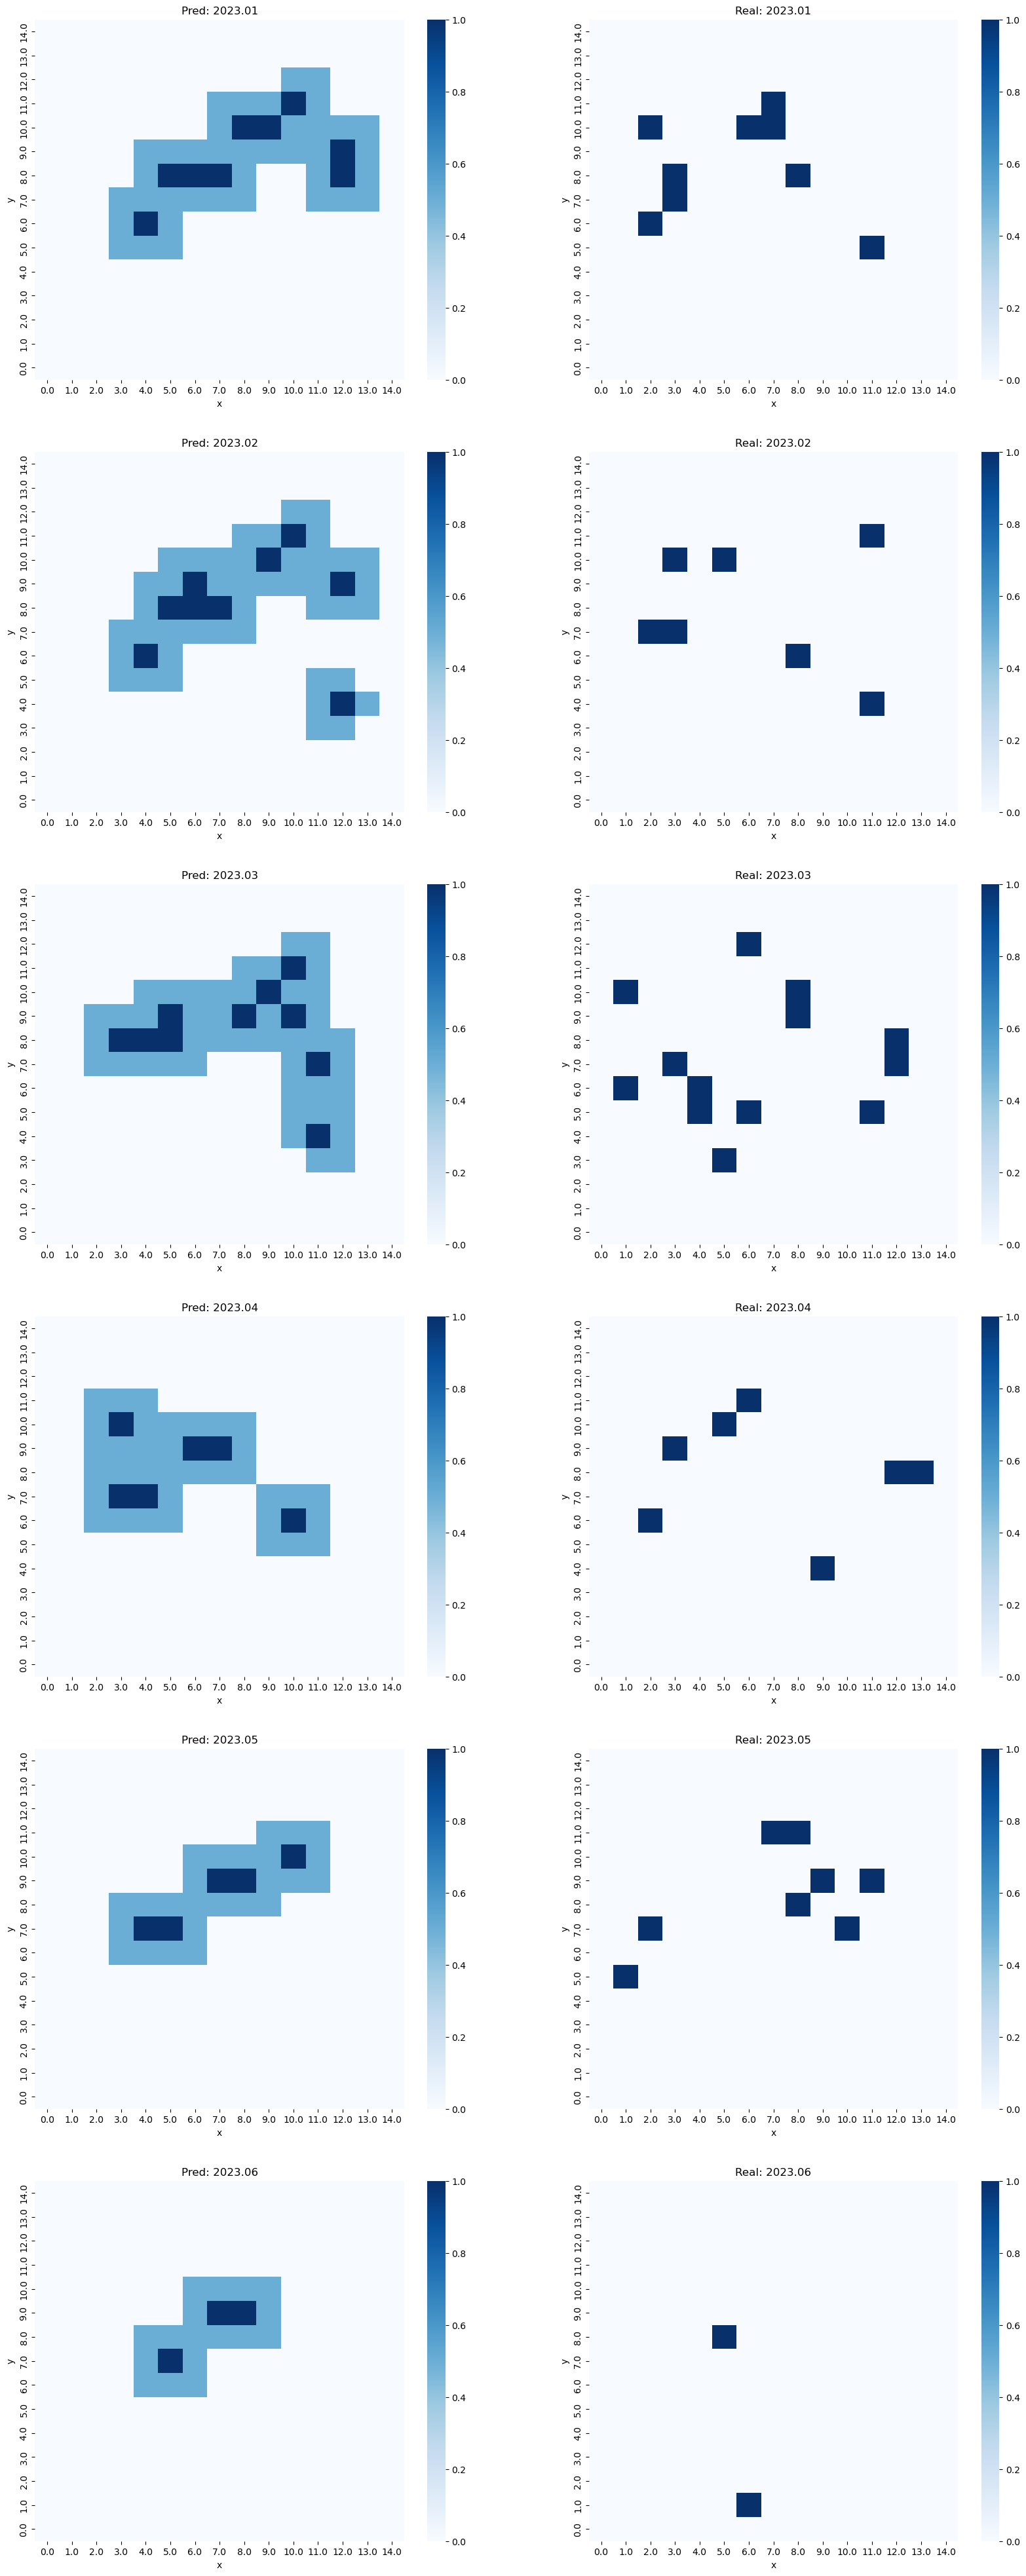

In [80]:
# 실제 화재 좌표와 예측 화재 좌표간의 비교 그래프
fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(20, 50))

sns.heatmap(pred_heatmap_1, cmap='Blues', ax=ax[0][0])
sns.heatmap(real_heatmap_1, cmap='Blues', ax=ax[0][1])
sns.heatmap(pred_heatmap_2, cmap='Blues', ax=ax[1][0])
sns.heatmap(real_heatmap_2, cmap='Blues', ax=ax[1][1])
sns.heatmap(pred_heatmap_3, cmap='Blues', ax=ax[2][0])
sns.heatmap(real_heatmap_3, cmap='Blues', ax=ax[2][1])
sns.heatmap(pred_heatmap_4, cmap='Blues', ax=ax[3][0])
sns.heatmap(real_heatmap_4, cmap='Blues', ax=ax[3][1])
sns.heatmap(pred_heatmap_5, cmap='Blues', ax=ax[4][0])
sns.heatmap(real_heatmap_5, cmap='Blues', ax=ax[4][1])
sns.heatmap(pred_heatmap_6, cmap='Blues', ax=ax[5][0])
sns.heatmap(real_heatmap_6, cmap='Blues', ax=ax[5][1])

ax[0][0].set_title('Pred: 2023.01')
ax[0][1].set_title('Real: 2023.01')
ax[1][0].set_title('Pred: 2023.02')
ax[1][1].set_title('Real: 2023.02')
ax[2][0].set_title('Pred: 2023.03')
ax[2][1].set_title('Real: 2023.03')
ax[3][0].set_title('Pred: 2023.04')
ax[3][1].set_title('Real: 2023.04')
ax[4][0].set_title('Pred: 2023.05')
ax[4][1].set_title('Real: 2023.05')
ax[5][0].set_title('Pred: 2023.06')
ax[5][1].set_title('Real: 2023.06')

In [81]:
# 라벨 저장
real_fires = df_real[df_real['fire'] == 1].values.tolist()
pred_fires = df_pred[df_pred['fire'] == 1].values.tolist()

In [82]:
# 전체 화재 중 예측한 좌표에서 정확히 화재가 발생한 정확도
correct = 0

for fire in real_fires:
    if fire in pred_fires: 
        correct += 1

print('전체 화재 중 예측한 곳에서 정확히 불이 난 횟수:', correct)
print('정확도:', correct / len(real_fires))

예측한 곳에서 정확히 불이 난 횟수: 1
정확도: 0.021739130434782608


In [83]:
# 전체 화재 중 예측한 좌표와 그 주변에서 화재가 발생한 정확도 (주변 8개의 좌표를 포함한다고 할 때)
correct = 0

for fire in real_fires:
    if fire in pred_fires: 
        correct += 1
    elif [fire[0], fire[1]+1, fire[2], fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1]-1, fire[2], fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1], fire[2]+1, fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1], fire[2]-1, fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1]+1, fire[2]+1, fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1]+1, fire[2]-1, fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1]-1, fire[2]+1, fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1]-1, fire[2]-1, fire[3]] in pred_fires:
        correct += 1

print('전체 화재 중 예측한 곳 주변좌표에서 불이 난 횟수:', correct)
print('정확도:', correct / len(real_fires))

예측한 곳 주변좌표에서 불이 난 횟수: 21
정확도: 0.45652173913043476


# 4. 시책 시행 후 2023.07~2023.12의 실제화재와 화재예측결과 비교

In [2]:
import pandas as pd
import requests
import json

In [3]:
# 2023년 전체 화재데이터 불러오기
# 시책은 2023.07~2023.12에 시행하였으며 예측한 좌표 및 주변좌표를 주기적으로 순찰
df_2023_fire = pd.read_csv('./data/fire_2023_full.csv')
df_2023_fire = df_2023_fire.loc[:, [
    '화재발생(년)', '화재발생(월)', '화재발생(일)', '화재발생(시)', '화재발생(분)', 
    '시도', '시군구', '읍면동', '지번동', '지번리', '세부주소', '도로명주소']
]

In [4]:
# 주소 정제
df_2023_fire['정제주소'] = df_2023_fire['시도'] + ' ' + df_2023_fire['시군구'] + ' ' + df_2023_fire['읍면동'] + ' ' + df_2023_fire['지번리'] + ' ' + df_2023_fire['세부주소']
df_2023_fire = df_2023_fire.drop(columns=['시도', '시군구', '읍면동', '지번동', '지번리', '세부주소', '도로명주소'])
df_2023_fire['경도'] = 0.
df_2023_fire['위도'] = 0.
df_2023_fire.head()

,화재발생(년),화재발생(월),화재발생(일),화재발생(시),화재발생(분),정제주소,경도,위도
0,2023,1,1,18,6,충청남도 부여군 규암면 신성리 212-1 주택 마당,0.0,0.0
1,2023,1,2,19,1,충청남도 부여군 은산면 가중리 111-1,0.0,0.0
2,2023,1,3,21,38,충청남도 부여군 홍산면 무정리 301,0.0,0.0
3,2023,1,5,15,13,충청남도 부여군 세도면 장산리 106-4,0.0,0.0
4,2023,1,5,17,54,충청남도 부여군 내산면 지티리 126-2,0.0,0.0


In [5]:
# 카카오맵 API 키 불러오기
API_KEY = 'c8d2487b6ee1ee531c4b6899126efe7f'
headers = {'Authorization' : 'KakaoAK '+API_KEY}
headers

{'Authorization': 'KakaoAK c8d2487b6ee1ee531c4b6899126efe7f'}

In [6]:
# 카카오맵 API 경도, 위도 함수 정의
def getLat(addr):
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + addr
    result = json.loads(str(requests.get(url, headers=headers).text))
    match_first = result['documents'][0]['address']
    return float(match_first['y'])

def getLng(addr):
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + addr
    result = json.loads(str(requests.get(url, headers=headers).text))
    match_first = result['documents'][0]['address']
    return float(match_first['x'])

In [7]:
# 카카오 api로 주소를 위도 경도로 변환
error = []
for i in df_2023_fire.index:
    try:
        lng = getLng(df_2023_fire['정제주소'][i])
        lat = getLat(df_2023_fire['정제주소'][i])
        df_2023_fire.loc[i,['경도']] = lng
        df_2023_fire.loc[i,['위도']] = lat

    except:
        print('error',i)
        error.append(i)
        
    
    if i%100 == 0:
        print('{} 번째 주소에 대한 좌표정보 불러오는 중...'.format(i)) 

0 번째 주소에 대한 좌표정보 불러오는 중...


In [8]:
# 위도 및 경도 체크
df_2023_fire.head()

,화재발생(년),화재발생(월),화재발생(일),화재발생(시),화재발생(분),정제주소,경도,위도
0,2023,1,1,18,6,충청남도 부여군 규암면 신성리 212-1 주택 마당,126.882676,36.323177
1,2023,1,2,19,1,충청남도 부여군 은산면 가중리 111-1,126.848754,36.300428
2,2023,1,3,21,38,충청남도 부여군 홍산면 무정리 301,126.782041,36.240264
3,2023,1,5,15,13,충청남도 부여군 세도면 장산리 106-4,126.988263,36.177446
4,2023,1,5,17,54,충청남도 부여군 내산면 지티리 126-2,126.738486,36.290436


In [9]:
# 부여 동서남북 가장 끝 좌표
LOWER = 36.0721
LEFT = 126.6796
UPPER = 36.3865
RIGHT = 127.07

In [10]:
# 위도, 경도 15, 15 좌표계로 변환
df_2023_fire['x'] = df_2023_fire['경도'].astype(float).map(lambda x: np.trunc((x - LEFT) / ((RIGHT - LEFT) / 15.)))
df_2023_fire['y'] = df_2023_fire['위도'].astype(float).map(lambda x: np.trunc((x - LOWER) / ((UPPER - LOWER) / 15.)))
df_2023_fire.head()

,화재발생(년),화재발생(월),화재발생(일),화재발생(시),화재발생(분),정제주소,경도,위도,x,y
0,2023,1,1,18,6,충청남도 부여군 규암면 신성리 212-1 주택 마당,126.882676,36.323177,7.0,11.0
1,2023,1,2,19,1,충청남도 부여군 은산면 가중리 111-1,126.848754,36.300428,6.0,10.0
2,2023,1,3,21,38,충청남도 부여군 홍산면 무정리 301,126.782041,36.240264,3.0,8.0
3,2023,1,5,15,13,충청남도 부여군 세도면 장산리 106-4,126.988263,36.177446,11.0,5.0
4,2023,1,5,17,54,충청남도 부여군 내산면 지티리 126-2,126.738486,36.290436,2.0,10.0


In [11]:
# 필요컬럼만 선별
df_2023_fire['년'] = df_2023_fire['화재발생(년)']
df_2023_fire['월'] = df_2023_fire['화재발생(월)']
df_fire = df_2023_fire.loc[:, ['년', '월', 'x', 'y']]
df_fire.head()

,년,월,x,y
0,2023,1,7.0,11.0
1,2023,1,6.0,10.0
2,2023,1,3.0,8.0
3,2023,1,11.0,5.0
4,2023,1,2.0,10.0


In [12]:
# 데이터파일 불러오기
df_real_fire = pd.read_csv('./data/preprocessed_fire_data.csv')
df_buildings = pd.read_csv('./data/preprocessed_buildings.csv')
df_pop = pd.read_csv('./data/coorded_old_population.csv')
df_weather = pd.read_csv('./data/preprocessed_weather.csv')

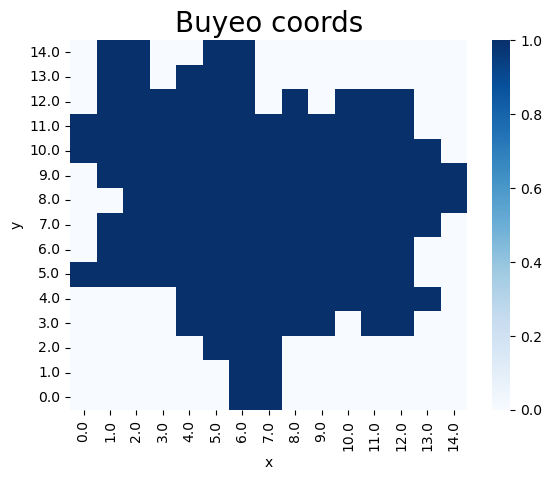

In [13]:
# 부여가 포함된 좌표만 걸러내기
# 인구분포 데이터와 화재 데이터를 결합하여 부여에 해당하는 좌표 얻기
df_pop_xy = df_pop.loc[:, ['x', 'y']]
df_fire_xy = df_real_fire.loc[:, ['x', 'y']]
df_buyeo = pd.concat([df_pop_xy, df_fire_xy])
df_buyeo = df_buyeo.drop_duplicates()
df_buyeo['val'] = 1
df_buyeo_heatmap = df_buyeo.pivot(index='y', columns='x', values='val').sort_index(ascending=False).fillna(0)
df_buyeo = df_buyeo.loc[:, ['x', 'y']]
ax = sns.heatmap(df_buyeo_heatmap, cmap='Blues')
plt.title('Buyeo coords', fontsize=20)
plt.show()

In [14]:
# 날짜와 좌표의 모든 조합 구하기
import itertools

year = [2023]
month = list(np.arange(start=1, stop=13))
full_date = list(itertools.product(year, month))
buyeo_coords = df_buyeo.values.tolist()

date_coords = list(itertools.product(full_date, buyeo_coords))
len(date_coords)

1632

In [15]:
# 모든 조합의 화재 발생여부 조사
real_feats = []

for date_coord in date_coords:
    feat = []
    # 날짜 및 좌표부터 추가: 년, 월, x, y
    feat.append(date_coord[0][0]) 
    feat.append(date_coord[0][1]) 
    feat.append(date_coord[1][0])
    feat.append(date_coord[1][1])

    # 인구수비율 및 노인인구수비율 추가: 인구수비율, 60세이상노인인구수비율
    fire_result =  df_fire[
        (df_fire['년'] == date_coord[0][0]) & 
        (df_fire['월'] == date_coord[0][1]) &
        (df_fire['x'] == date_coord[1][0]) &
        (df_fire['y'] == date_coord[1][1])
    ]

    if len(fire_result) == 0:
        feat.append(0.)
    else:
        feat.append(1.)



    real_feats.append(feat)

In [16]:
# 조사 결과를 데이터프레임으로 변환
df_real = pd.DataFrame(real_feats, columns=[
    'year', 'month', 'x', 'y', 'fire'
])
df_real = df_real.loc[:, ['month', 'x', 'y', 'fire']]
print(len(df_real))
df_real.head()

1632


,month,x,y,fire
0,1,0.0,11.0,0.0
1,1,1.0,5.0,0.0
2,1,1.0,6.0,0.0
3,1,1.0,7.0,0.0
4,1,1.0,9.0,0.0


In [17]:
# 화재예측결과 데이터 불러오기
df_pred = pd.read_csv('./data/2023_prediction.csv')
df_pred.head()
len(df_pred)

1632

In [18]:
# 화재예측지역은 1, 해당지역 주변지역은 0.5로 변환
check_coord = df_pred.loc[:, ['month', 'x', 'y']].values.tolist()
for idx in df_pred[df_pred['fire'] == 1].index:
    month = df_pred.iloc[idx]['month']
    x = df_pred.iloc[idx]['x']
    y = df_pred.iloc[idx]['y']
    if [month, x+1, y] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x+1) & (df_pred['y'] == y)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x-1, y] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x-1) & (df_pred['y'] == y)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x, y+1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x) & (df_pred['y'] == y+1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x, y-1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x) & (df_pred['y'] == y-1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x+1, y+1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x+1) & (df_pred['y'] == y+1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x+1, y-1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x+1) & (df_pred['y'] == y-1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x-1, y+1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x-1) & (df_pred['y'] == y+1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5
    if [month, x-1, y-1] in check_coord:
        i = df_pred[(df_pred['month'] == month) & (df_pred['x'] == x-1) & (df_pred['y'] == y-1)].index[0]
        if df_pred.iloc[i, df_pred.columns.get_loc('fire')] != 1:
            df_pred.iloc[i, df_pred.columns.get_loc('fire')] = 0.5

In [19]:
# 실제 화재 히트맵 생성
real_heatmap_7 = df_real[df_real['month'] == 7].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
real_heatmap_8 = df_real[df_real['month'] == 8].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
real_heatmap_9 = df_real[df_real['month'] == 9].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
real_heatmap_10 = df_real[df_real['month'] == 10].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
real_heatmap_11 = df_real[df_real['month'] == 11].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
real_heatmap_12 = df_real[df_real['month'] == 12].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)

# 예측 화제 히트맵 생성
pred_heatmap_7 = df_pred[df_pred['month'] == 7].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
pred_heatmap_8 = df_pred[df_pred['month'] == 8].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
pred_heatmap_9 = df_pred[df_pred['month'] == 9].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
pred_heatmap_10 = df_pred[df_pred['month'] == 10].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
pred_heatmap_11 = df_pred[df_pred['month'] == 11].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)
pred_heatmap_12 = df_pred[df_pred['month'] == 12].pivot(index='y', columns='x', values='fire').sort_index(ascending=False).fillna(0)

Text(0.5, 1.0, 'Real: 2023.12')

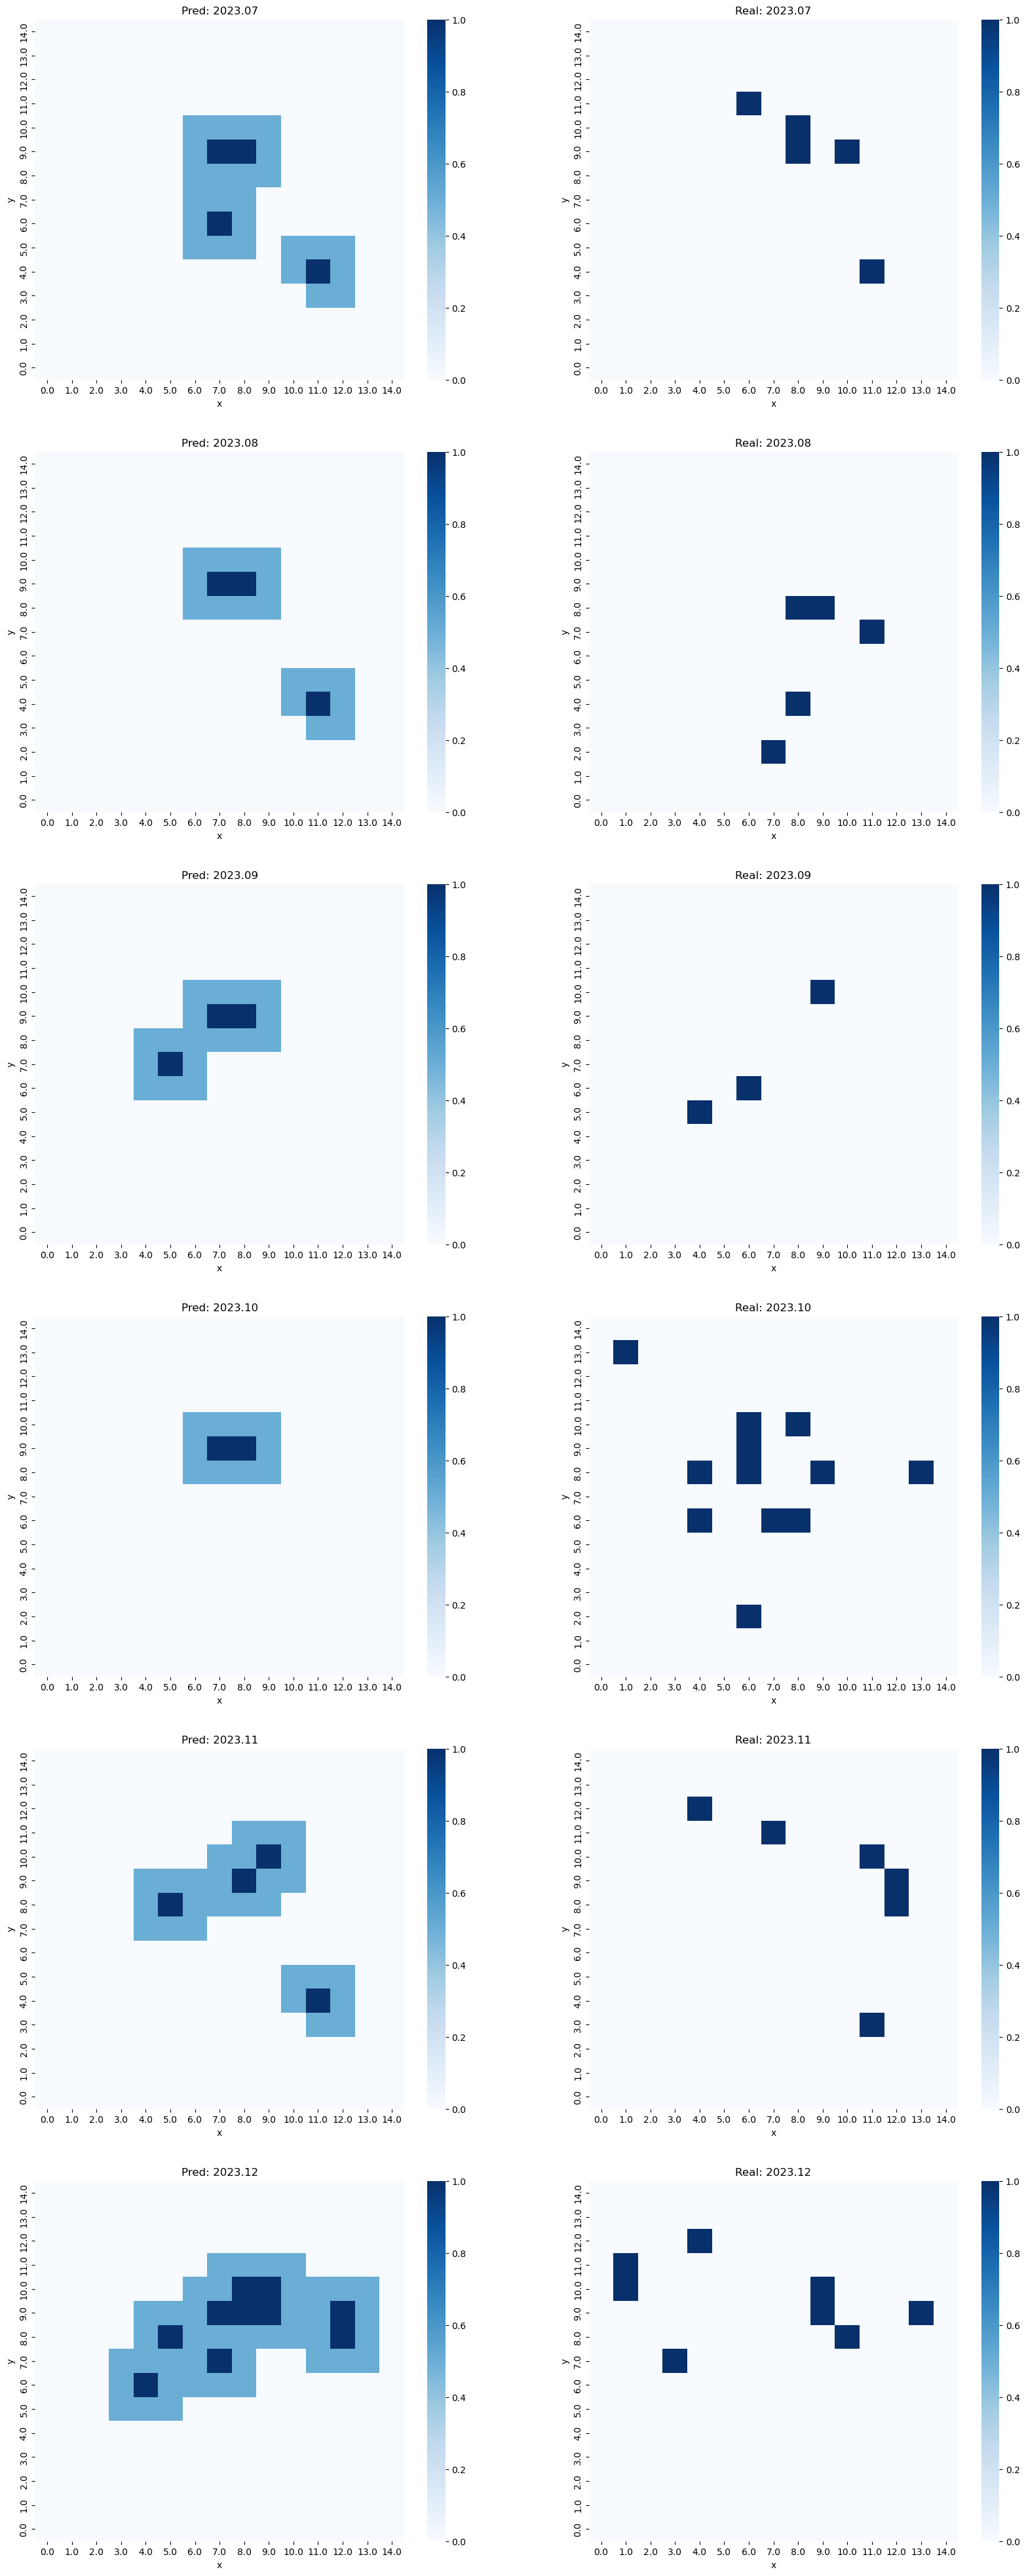

In [20]:
# 실제 화재 좌표와 예측 화재 좌표간의 비교 그래프
fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(20, 50))

sns.heatmap(pred_heatmap_7, cmap='Blues', ax=ax[0][0])
sns.heatmap(real_heatmap_7, cmap='Blues', ax=ax[0][1])
sns.heatmap(pred_heatmap_8, cmap='Blues', ax=ax[1][0])
sns.heatmap(real_heatmap_8, cmap='Blues', ax=ax[1][1])
sns.heatmap(pred_heatmap_9, cmap='Blues', ax=ax[2][0])
sns.heatmap(real_heatmap_9, cmap='Blues', ax=ax[2][1])
sns.heatmap(pred_heatmap_10, cmap='Blues', ax=ax[3][0])
sns.heatmap(real_heatmap_10, cmap='Blues', ax=ax[3][1])
sns.heatmap(pred_heatmap_11, cmap='Blues', ax=ax[4][0])
sns.heatmap(real_heatmap_11, cmap='Blues', ax=ax[4][1])
sns.heatmap(pred_heatmap_12, cmap='Blues', ax=ax[5][0])
sns.heatmap(real_heatmap_12, cmap='Blues', ax=ax[5][1])

ax[0][0].set_title('Pred: 2023.07')
ax[0][1].set_title('Real: 2023.07')
ax[1][0].set_title('Pred: 2023.08')
ax[1][1].set_title('Real: 2023.08')
ax[2][0].set_title('Pred: 2023.09')
ax[2][1].set_title('Real: 2023.09')
ax[3][0].set_title('Pred: 2023.10')
ax[3][1].set_title('Real: 2023.10')
ax[4][0].set_title('Pred: 2023.11')
ax[4][1].set_title('Real: 2023.11')
ax[5][0].set_title('Pred: 2023.12')
ax[5][1].set_title('Real: 2023.12')

In [21]:
# 라벨 저장
real_fires = df_real[(df_real['month'] > 6) & (df_real['fire'] == 1)].values.tolist()
pred_fires = df_pred[(df_pred['month'] > 6) & (df_pred['fire'] == 1)].values.tolist()

In [22]:
# 전체 화재 중 예측한 좌표 그 자체에서의 화재 정확도
correct = 0

for fire in real_fires:
    if fire in pred_fires: 
        correct += 1

print('전체 화재 중 예측한 곳에서 화재가 난 횟수:', correct)
print('정확도:', correct / len(real_fires))

전체 화재 중 예측한 곳에서 화재가 난 횟수: 4
정확도: 0.10256410256410256


In [23]:
# 전체 화재 중 예측한 좌표 및 그 주변에서의 화재 정확도 (주변 8개의 좌표를 포함한다고 할 때)
correct = 0

for fire in real_fires:
    if fire in pred_fires: 
        correct += 1
    elif [fire[0], fire[1]+1, fire[2], fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1]-1, fire[2], fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1], fire[2]+1, fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1], fire[2]-1, fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1]+1, fire[2]+1, fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1]+1, fire[2]-1, fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1]-1, fire[2]+1, fire[3]] in pred_fires:
        correct += 1
    elif [fire[0], fire[1]-1, fire[2]-1, fire[3]] in pred_fires:
        correct += 1

print('전체 화재 중 예측한 곳 주변좌표에서 불이 난 횟수:', correct)
print('정확도:', correct / len(real_fires))

전체 화재 중 예측한 곳 주변좌표에서 불이 난 횟수: 18
정확도: 0.46153846153846156


In [27]:
# 2012년부터 2022년까지의 화재를 월별 평균낸 결과
df_all = pd.read_csv('./data/preprocessed_data.csv')
df_all = df_all.groupby('month').sum() / 11
df_all['fire'].iloc[6:13]

month
7      7.181818
8      8.000000
9      8.181818
10     8.181818
11     8.272727
12    11.545455
Name: fire, dtype: float64

In [28]:
# 2022년의 화재를 월별로 분류한 결과
df_2022 = pd.read_csv('./data/preprocessed_fire_data.csv')
df_2022['fire'] = 1.
df_2022 = df_2022[df_2022['년']==2022].groupby('월').sum()
df_2022['fire'].iloc[6:13]

월
7      3.0
8      6.0
9      8.0
10     9.0
11     6.0
12    19.0
Name: fire, dtype: float64

In [29]:
#2023년의 화재를 월별로 분류한 결과
df_2023 = df_real.groupby('month').sum()
df_2023['fire'].iloc[6:13]

month
7      5.0
8      5.0
9      3.0
10    12.0
11     6.0
12     8.0
Name: fire, dtype: float64

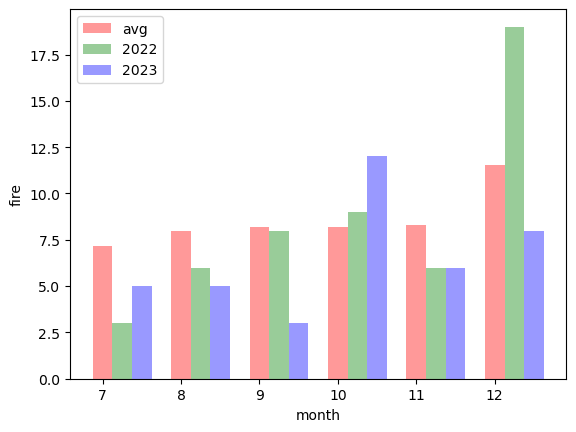

In [30]:
# 2022년까지의 월별 평균화재횟수, 2022년 월별화재횟수, 2023년 월별화재횟수 비교
# 
bar_width = 0.25
plt.bar(np.arange(7, 13), df_all['fire'].iloc[6:13], bar_width, alpha=0.4, color='red', label='avg')
plt.bar(np.arange(7, 13)+bar_width, df_2022['fire'].iloc[6:13], bar_width, alpha=0.4, color='green', label='2022')
plt.bar(np.arange(7, 13)+bar_width*2, df_2023['fire'].iloc[6:13], bar_width, alpha=0.4, color='blue', label='2023')
plt.xlabel('month')
plt.ylabel('fire')
plt.legend()